A partir del dataset de residuos solidos construido con la participacion de cada estudiante de la materia, construir lo siguientes:

1. Un modelo que convierta (colorize) una imagen en escala de grises a una imagen de color.
2. Genere de manera aleatoria imagenes de el tipo de residuo solido que le toco aportar para el dataset.

Para la defensa, el modelo debe ser 100% funcional, se debe suministrar todos los recursos empleados para su construccion 
(datasets, librerias, github, entre otros), los cuales en caso de ser muy grandes se debe ubicar en un repositorio que pueda ser accedido publicamente.

##Bibliotecas

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
from PIL import Image, ImageOps

import random 
from skimage import io
import matplotlib.pyplot as plt

In [2]:
dir_path="/content/drive/MyDrive/dataset_basura"
classes = ["botelleas_vidrio"]
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{dir_path}/{lab}')
  if lab in ['botelleas_vidrio']:
    print(f'Categoría: {lab}. Imágenes: {len(paths)}')
    paths = [p for p in paths if p[-3:] == "jpg"]
    imgs += [f'{dir_path}/{lab}/{img}' for img in paths]
    labels += [i]*len(paths)

Categoría: botelleas_vidrio. Imágenes: 1006


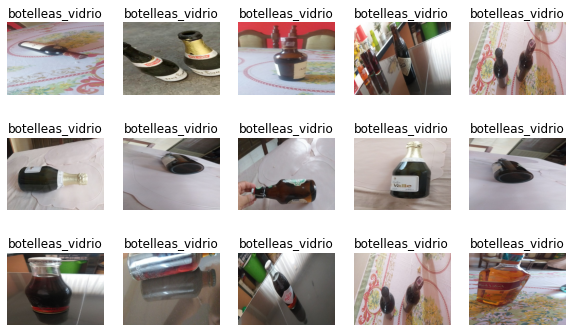

In [4]:
def graficar():
  fig, axs = plt.subplots(3,5, figsize=(10,6))
  for _ax in axs:
    for ax in _ax:
      ix = random.randint(0, len(imgs)-1)
      img = io.imread(imgs[ix])
      ax.imshow(img)
      ax.axis('off')
      ax.set_title(classes[labels[ix]])
  plt.show()
graficar()

In [5]:
imagenes = [Image.open(i).resize((60,60)) for i in imgs]

In [6]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, imagenes, labels):
        self.imgs = torch.tensor([np.array(i).flatten() / 255. for i in imagenes], dtype=torch.float, device=device)
        self.labels = torch.tensor([i for i in labels], dtype=torch.long, device=device)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        return self.imgs[ix], self.labels[ix]

train = Dataset(imagenes, labels)
len(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """


1006

In [7]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 10800]), torch.Size([32]))

In [8]:
import torch.nn as nn

def block(n_in, n_out):
  return nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU(inplace=True)
  )

class MLP(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.fc1 = block(input_size, 150)
    self.fc2 = block(150, 100)
    self.fc3 = nn.Linear(100, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [9]:
n_in, n_out = 10, 60*60*3
generator = MLP(n_in, n_out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


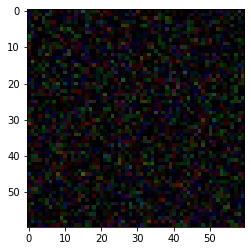

In [11]:
plt.imshow(output[0].reshape(60,60,3).detach().numpy())
plt.show()

In [20]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):
  g.to(device)
  d.to(device)
  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-6)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
  crit = nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:
    for X, y in progress_bar(dataloader, parent=mb):
      #X, y = X.to(device), y.to(device)  
      # entrenamos el discriminador
      g.eval()
      d.train()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   input del discrminator
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #   gorund truth para el discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
      #   optimización
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   salidas del discriminador
      d_output = d(genenerated_images)
      #   gorund truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))    
    hist['d_loss'].append(np.mean(d_loss))
  return hist

In [18]:
discriminator = MLP(60*60*3, 1)
output = discriminator(torch.randn(64, 60*60*3))
output.shape

torch.Size([64, 1])

In [19]:
output = generator(torch.randn(64, 10))
output.shape

torch.Size([64, 10800])

In [21]:
hist = fit(generator, discriminator, dataloader)

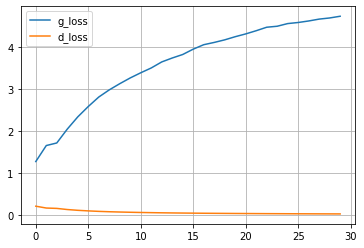

In [15]:
import pandas as pd 

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

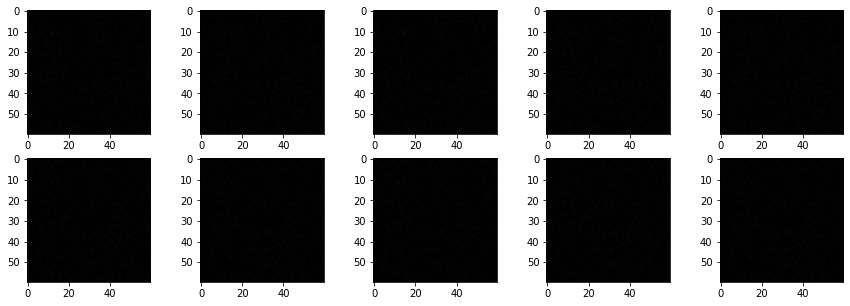

In [16]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(60,60,3).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()